In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Frequency Oracle

In [2]:
df = pd.read_csv('taxi_day.csv', 
    dtype={'taxi_id':int, 'date_time':object, 'location_id':int}, 
    parse_dates=['date_time'], 
    infer_datetime_format=True)
df.tail(5)

,date_time,taxi_id,location_id
1625183,2008-02-03 13:30:00,10313,276
1625184,2008-02-03 13:30:00,10335,744
1625185,2008-02-03 13:30:00,10337,162
1625186,2008-02-03 13:30:00,10340,668
1625187,2008-02-03 13:30:00,10343,312


## Distance matrix

In [3]:
from geopy.distance import geodesic

latitude_min = 39.81
longitude_min = 116.245
latitude_step = 0.0045 # 500m
longitude_step = 0.0058 # 495m
latitude_num = 50
longitude_num = 50
latitude_max = latitude_min + latitude_num*latitude_step
longitude_max = longitude_min + longitude_num*longitude_step

d = latitude_num*longitude_num
coordinate = np.zeros((d, 2))
for i in range(d):
    coordinate[i] = ((latitude_min + latitude_step*int(i/longitude_num) + latitude_step/2), (longitude_min + longitude_step*(i%longitude_num) + longitude_step/2))
dist_mat = np.zeros((d, d))
for i in range(d):
    for j in range(d):
        dist_mat[i][j] = geodesic(coordinate[i], coordinate[j]).m

## Expected distance

In [4]:
data = np.array(df['location_id'])
d = latitude_num*longitude_num
pi = np.zeros(d)
for i in data:
    pi[i] += 1
pi /= pi.sum()

In [26]:
alpha = 0.0005
p_mat = np.exp(-alpha*dist_mat/2)
for i, _ in enumerate(p_mat):
    p_mat[i] /= p_mat[i].sum()
(pi*(dist_mat*p_mat).sum(axis=1)).sum()

6016.819208912342

In [23]:
from math import exp

epsilon = 8
p_mat_grr = np.full((d, d), 1/(exp(epsilon) + d - 1))
p_mat_grr[np.diag_indices_from(p_mat_grr)] = exp(epsilon)/(exp(epsilon) + d - 1)
(pi*(dist_mat*p_mat_grr).sum(axis=1)).sum()

6140.51793393686

## Randomizer

In [12]:
from xxhash import xxh32

def GRR(data, epsilon):
    global d
    p = exp(epsilon)/(exp(epsilon) + d - 1)
    q = 1/(exp(epsilon) + d - 1)
    aggregated_data = np.zeros(d, dtype=int)
    for item in data:
        private_data = item
        if np.random.random_sample() > p - q:
            private_data = np.random.randint(0, d)
        aggregated_data[private_data] += 1
    return (aggregated_data - len(data)*q)/(p - q)

def EM(data, alpha):
    global d
    global dist_mat
    p_mat = np.exp(-alpha*dist_mat/2)
    for i, _ in enumerate(p_mat):
        p_mat[i] /= p_mat[i].sum()
    universe = np.arange(d)
    aggregated_data = np.zeros(d)
    for item in data:
        aggregated_data[np.random.choice(universe, p=p_mat[item])] += 1
    return aggregated_data

def OUE(data, epsilon):
    global d
    p = 1 - 1/2
    q = 1/(exp(epsilon)+1)
    aggregated_data = np.zeros(d)
    for item in data:
        private_data = np.zeros(d)
        private_data[item] = 1
        aggregated_data += np.where(private_data == 1, 
            np.random.binomial(1, p, d), 
            np.random.binomial(1, q, d))
    return (aggregated_data - len(data)*q)/(p - q)

def OLH(data, epsilon):
    global d
    g = int(round(exp(epsilon))) + 1
    p = exp(epsilon)/(exp(epsilon) + g - 1)
    q = 1/(exp(epsilon) + g - 1)
    aggregated_data = np.zeros(d)
    for i, item in enumerate(data):
        private_data = (xxh32(str(item), seed=i).intdigest() % g)
        if np.random.random_sample() > p - q:
            private_data = np.random.randint(0, g)
        for j in range(d):
            if private_data == (xxh32(str(j), seed=i).intdigest() % g):
                aggregated_data[j] +=  1
    return (g*aggregated_data - len(data))/(p*g - 1)

In [ ]:
from scipy import stats

## Metric

In [19]:
def jaccard_index(top_k, est_top_k):
    return len(np.intersect1d(top_k, est_top_k))/len(np.union1d(top_k, est_top_k))

def relative_error(freq, est_freq):
    freq /= freq.sum()
    est_freq /= est_freq.sum()
    return (abs(freq - est_freq)/(freq + np.finfo(np.float32).eps)).mean()

def utility(freq, est_freq):
    k = 100
    # jaccard index
    true_top_k = np.argpartition(-freq, k)[:k]
    est_top_k = np.argpartition(-est_freq, k)[:k]
    jaccard_index = len(np.intersect1d(true_top_k, est_top_k))/len(np.union1d(true_top_k, est_top_k))
    # relative error
    freq /= freq.sum()
    est_freq /= est_freq.sum()
    relative_error = (abs(freq - est_freq)/(freq + np.finfo(np.float32).eps)).mean()
    return jaccard_index

0.5151515151515151
0.04712041884816754
0.43884892086330934
0.4492753623188406


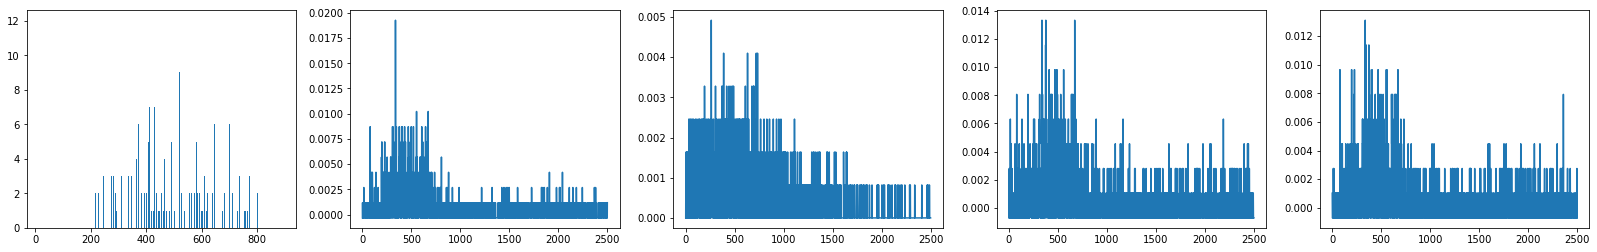

In [27]:
current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = '1min'

data = np.array(df.loc[df['date_time']==current_time+pd.Timedelta(5*interval)]['location_id'])
freq_grr = GRR(data, epsilon)
freq_em = EM(data, alpha)
freq_oue = OUE(data, epsilon)
freq_olh = OLH(data, epsilon)

# data = np.array(df.loc[df['date_time']==current_time+pd.Timedelta(10*interval)]['location_id'])
freq = np.zeros(d)
for loc in data:
    freq[loc] += 1

print(utility(freq, freq_grr))
print(utility(freq, freq_em))
print(utility(freq, freq_oue))
print(utility(freq, freq_olh))

plt.figure(figsize=(28, 4))
plt.subplot(151)
plt.hist(data, d)
plt.subplot(152)
plt.plot(freq_grr)
plt.subplot(153)
plt.plot(freq_em)
plt.subplot(154)
plt.plot(freq_oue)
plt.subplot(155)
plt.plot(freq_olh)
plt.show()